In [1]:
import numpy as np
from numpy import sin,cos
import matplotlib.pyplot as plt
import scipy.integrate
import ipywidgets as widgets

# Schrödinger Equation for a Box Potential

We want to solve the Schrödinger equation numerically.

$$
  \mathcal{H}\,|\psi\rangle = E\,|\psi\rangle
  \qquad\text{with }
  \mathcal{H} = - \frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x)
$$

This example considers a box potential:
$$
V(x) = 
\begin{cases}
0 \text{ for } 0<x<1 \\
\infty \text{ otherwise}
\end{cases}
$$

In this case, the wave function vanishes everywhere except in the interval $[0,1]$, where it is described by the differential equation
$$
  \mathcal{H}\,|\psi\rangle 
  % = - \frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x)\,|\psi\rangle
  = - \frac{\hbar^2}{2m} \frac{d^2}{dx^2}\,|\psi\rangle
 = E\,|\psi\rangle
$$

## Runge-Kutta Algorithm

We can solve this with the tools for first-order initial value problems. In this case, we need to introduce a dynamic variable and a generalized velocity:
$$
y = \left(\begin{array}{x} \psi \\ \psi' \end{array}\right)
\qquad
g_E(y)
= \left(\begin{array}{c} \psi' \\ \psi'' \end{array}\right)
= \left(\begin{array}{c}\psi' \\ -\frac{2mE}{\hbar^2}\psi\end{array}\right)
= \left(\begin{array}{cc} 
    0 & 1 \\
    -\frac{2mE}{\hbar^2} & 0
\end{array}\right)\, y
$$

We will use $2mE/\hbar^2=1$, i.e. we will measure the energy in units of $\hbar^2/2m$.

In [2]:
class genvelocity:
    def __init__(self,E):
        self.E = E

    def __call__(self,t,y):
        return np.array([y[1], -self.E*y[0]])

With this generalized velocity, we can actually run the integration, using e.g. the Runge-Kutta algorithm implemented in `scipy.integrate`.

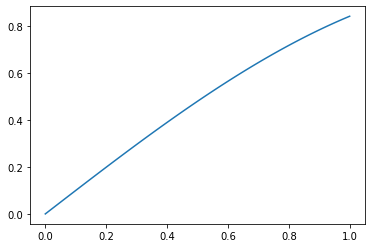

In [3]:
g = genvelocity(1)
y0 = np.array([0,1])

sol = scipy.integrate.solve_ivp(g,[0,1],y0,max_step=0.01)
plt.plot(sol.t,sol.y[0]);

The Runge-Kutta ensures that the Schrödinger equation is satisfied anywhere within the interval $(0,1)$, but the boundary condition $\psi(0)=\psi(1)=0$ is not satisfied at the upper edge. To satisfy the boundary condition, we need to adjust the energy $E$ of the particle.

In [4]:
def draw_rk(E):
    sol = scipy.integrate.solve_ivp(genvelocity(E),[0,1],[0,1],max_step=1e-3)
    plt.plot(sol.t,sol.y[0]);
        
widgets.interact(draw_rk, E=widgets.FloatLogSlider(min=0, max=4, value=5, continuous_update=False));

interactive(children=(FloatLogSlider(value=5.0, continuous_update=False, description='E'), Output()), _dom_cla…

In [5]:
def search_rk (E1,E2):

    d1 = scipy.integrate.solve_ivp(genvelocity(E1),[0,1],[0,1]).y[0,-1]
    d2 = scipy.integrate.solve_ivp(genvelocity(E2),[0,1],[0,1]).y[0,-1]
        
    while abs(d2) > 1e-15:
        
        # subsequent guesses are done via secant method
        E3 = (E1*d2 - E2*d1) / (d2 - d1)
        d3 = scipy.integrate.solve_ivp(genvelocity(E3),[0,1],[0,1]).y[0,-1]
        
        d1=d2
        d2=d3
        E1=E2
        E2=E3
        
    return E3

Found eigenvalue:      E = 9.865586208108386      n = sqrt(E)/pi = 0.9997964152421556


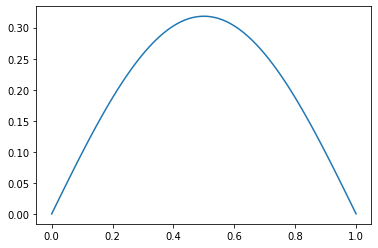

In [6]:
E1 = search_rk(1,2)

print(f"Found eigenvalue:      E = {E1}      n = sqrt(E)/pi = {np.sqrt(E1)/np.pi}")

sol = scipy.integrate.solve_ivp(genvelocity(E1),[0,1],[0,1],max_step=0.01)
plt.plot(sol.t,sol.y[0]);

Found eigenvalue:      E = 39.459063059835785      n = sqrt(E)/pi = 1.9995096835574986


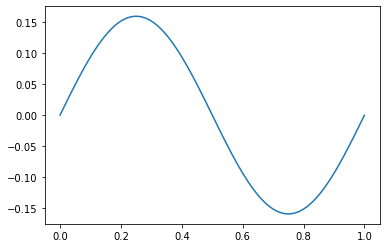

In [7]:
E1 = search_rk(50,60)

print(f"Found eigenvalue:      E = {E1}      n = sqrt(E)/pi = {np.sqrt(E1)/np.pi}")

sol = scipy.integrate.solve_ivp(genvelocity(E1),[0,1],[0,1],max_step=0.01)
plt.plot(sol.t,sol.y[0]);

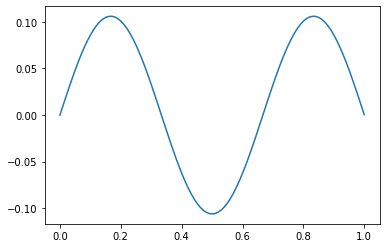

In [8]:
E1 = search_rk(80,90)

sol = scipy.integrate.solve_ivp(genvelocity(E1),[0,1],[0,1],max_step=0.01)
plt.plot(sol.t,sol.y[0]);

# Implementation with the Numerov Method

The Runge-Kutta method requires that we transscribe the Schrödinger equation as a first order ODE by explicitly introducing the first derivative of the wave function as a component of a dynamical variable. In quantum mechanics, this first derivative $\psi'$ does not have a physical meaning, and its introduction is quite artificial.

Alternatively, we can use the Numerov method, that allows us to integrate the second order ODE directly.

In [9]:
def numerov(x,q,s):

    u = np.zeros(len(q))
    u[0] = 0
    u[1] = x[1]-x[0]

    for i in range(1,len(u)-1):
        g = (x[i]-x[i-1])**2 / 12.
        c0 = 1 + g * q[i-1]
        c1 = 2 - 10 * g * q[i]
        c2 = 1 + g * q[i+1]
        d  = g * (s[i+1] + s[i-1] + 10*s[i])
        u[i+1] = ( c1*u[i] - c0*u[i-1] + d ) / c2

    return u

We can verify that the numerov method yields the same wave functions as the Runge-Kutta method.

In [10]:
def draw_num(E):
    x = np.linspace(0,1,1000)
    q = E*np.ones_like(x)
    s = np.zeros_like(x)

    psi = scipy.integrate.solve_ivp(genvelocity(E),[0,1],[0,1],max_step=1e-3)
    plt.plot(x,psi);
        
widgets.interact(draw_rk, E=widgets.FloatLogSlider(min=0, max=4, value=5, continuous_update=False));

interactive(children=(FloatLogSlider(value=5.0, continuous_update=False, description='E'), Output()), _dom_cla…